In [1]:
import numpy as np
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['text.usetex'] = True

# We now come to simulate the system by first constructing the mass balance equation then simulate it.

Since we are designing a three-phase catalytic fludiized bed reactor. 

The reactant (Hydrogen) will first transfer from the gas phase to the liquid phase. 
Then it diffuses from the liquid phase to the catalyst surface. 

However, since we have assumed that the hydrogen is in excess. Thus, here we do not consider the Hydrogen concentration profile with respect to the different parameters. 

And we focus on that of Benzene, Cyclohexene, and Cyclohexane. 

## Material Balance for the reactant in the liquid phase with axialy dispersed flow [5] [6]

$$
\varepsilon_l E_{zl} \dfrac{d^2 C_l}{d z^2} - U_l \dfrac{d C_l}{dz} +k_l a  (\dfrac{C_g}{H_e} - C_l) - k_s a_p \varepsilon_s (C_l - C_s) = 0 \tag{1}
$$

where

$\varepsilon_g, \varepsilon_l, \varepsilon_s$ are the gas, liquid and solid holdup respectively 

$E_{zl}$ is the liquid phase axial dispersion coefficient 

$U_g, U_l$ are the superficial gas and liquid velocities

$C_g, C_l, C_s$ are the reactant concentration in the bulk gas, bulk liquid and at the catalyst surface respectively

$z$ is the axial distance from the bottom of the bed

$k_l a$ is the overall volumetric gas-liquid mass transfer coefficient

$k_l$ is the gas-liquid mass transfer coefficient

$k_s$ is the liquid-solid mass transfer coefficient 

$a$ is the gas-liquid interfacial surface area per volume of the bed

$H_e$ is the Henry constant

The gas used is sparingly soluble in the liquid mixture (Benzene, water film of catalyst). 

But since the liquid is the continuous phase in the three-phase fluidized bed reactor and at high pressure, the gas-side mass transfer resistance we assume is negligible. 

Thus, the overall gas-liquid mass transfer coefficient, $k_l$ will be equal to the volumetric liquid-side mass transfer coefficient, $k_l a$, where $k_l$ is the liquid-side mass transfer coefficient and $a$ is the gas-liquid interfacial area per unit volume of the bed. 

In this case, we use an ANN approach, which takes into account of 6 literature reported models to correlate the parameter needed for our reactor design [1].

In [2]:
from Overall_Gas_Liquid_mass_transfer_coefficient import SimpleNN

def cal_Kl_a():
    """Overall gas-liquid mass transfer coefficient"""
    
    # Mass transfer parameters from the image
    weights_hidden = np.array([
        [2.173, -0.087, 0.369, -0.353, -2.287],
        [-1.481, 0.937, -0.162, -1.244, 2.948],
        [-2.315, 1.186, -0.837, 0.620, -0.083],
        [1.042, 1.215, -1.050, 0.558, -4.776],
        [-3.180, 1.968, -1.054, 1.470, -0.721]
    ])

    biases_hidden = np.array([-2.785, 1.203, -0.217, -2.255, 0.248])
    weights_output = np.array([[0.831], [1.314], [-1.527], [0.845], [0.856]])
    bias_output = np.array([-0.4126])

    # Initialize the neural network with the provided weights and biases
    nn = SimpleNN(weights_hidden, biases_hidden, weights_output, bias_output)

    # Input
    input_size = 5  
    
    # solid holdup
    eps_s = cal_holdups()[1]
    
    x = np.array([d_p, rho_p, U_l, U_g, eps_s])
    
    # Perform a forward pass
    output = nn.forward_pass(x)
    return output[0]

Network output (k_l a): [1.7574] [s^-1]


### Particle surface area per unit volume of solids, $a_p$
$$
a_p = \dfrac{6 \cdot \varepsilon_s}{d_p}
$$

In [3]:
def cal_a_p():
    """ Particle surface area per unit volume of solids """
    
    eps_s = cal_holdups()[1]
    
    return 6 * eps_s / d_p

### Axial dispersion coefficient, $E_l$, (Kim and Kim, 1983) [2]

$$
E_l = d_p U_l \left[20.19 \, (\dfrac{d_p}{D_c})^{1.66} \, (\dfrac{U_l}{U_l + U_g})^{1.03}\right]^{-1}
$$

In [4]:
def cal_E_l():
    """ Axial dispersion coefficient (kim and kim) [2]"""
    numer = d_p * U_l
    denom = 20.19 * (d_p/D_c)**(1.66) * (U_l / (U_l + U_g))**(1.03)
    
    if numer == 0: 
        return 0
    
    return numer / denom

### Liquid-solid mass transfer coefficient, $k_s$, (Arters and Fan, 1986) [3]

$$
k_s = \dfrac{D_m}{d_p} \, \left[0.228 \, (1 + 0.0826 \, Re_g^{0.623}) \, Ga^{0.323} \, Sc^{0.4} (\dfrac{\rho_p - \rho_l}{\rho_l})^{0.3}\right]
$$

$$
Sc = \dfrac{\mu_l}{\rho_l \cdot D_m} 
\hspace{1cm}
\text{(Schimdt Number)}
$$

$$
Re_g = \dfrac{U_g \, d_p \, \rho_g}{\mu_g}
\hspace{1cm}
\text{(Reynolds Number)}
$$

$$
Ga = \dfrac{d_p^3 \, rho_l^2 \, g}{\mu_l^2}
\hspace{1cm}
\text{(Galileo Number)}
$$

In [5]:
def cal_k_s():
    """Liquid-solid mass transfer coefficient (Arters and Fan, 1986) [3]"""
    
    def Re_g():
        """Reynolds number of gas"""
        return (U_g * d_p * rho_g) / mu_g
    
    def Sc():
        """Scimidt Number"""
        return mu_l / (rho_l * Dm)
    
    def Ga():
        """Galileo Number"""
        return (d_p**3 * rho_l**2 * 9.3) / mu_l**2
        
    term1 = 0.228 * (1 + 0.0826 * Re_g()**(0.623)) * Ga()**(0.323) * Sc()**(0.4)
    term2 = ((rho_p - rho_l)/rho_l)**(0.3) * Dm / d_p
    
    return term1 * term2

### Phase Holdups $(\varepsilon_g, \varepsilon_l, \varepsilon_s)$ (Begovich and Watson, 1978) [4]

\begin{aligned}
\varepsilon_g &= 0.048 \, U_g^{0.72} \, d_p^{0.168} \, D_c^{-0.125} \\
\varepsilon_s &= 1 - 0.371 \, U_l^{0.271} \, U_g^{0.041} (\rho_p - \rho_l)^{-0.316} \, d_p^{-0.268} \mu_l^{0.055} D_c^{-0.033}\\
\varepsilon_l &= 1 - \varepsilon_g - \varepsilon_g
\end{aligned}

In [6]:
def cal_holdups():
    """
    
    Calculate gas, solids, and liquid holdups ensuring they sum to 1. (Begovich and Watson, 1978) [4]
    
    Parameters:
    U_g: Gas velocity
    U_l: Liquid velocity
    d_p: Particle diameter
    D_c: Column diameter
    rho_p: Particle density
    rho_l: Liquid density
    mu_l: Liquid viscosity

    Returns:
    A tuple of (eps_g, eps_s, eps_l) representing gas, solids, and liquid holdups.
    """
    # Check if either U_g or U_l is zero
    if U_g == 0 or U_l == 0:
        # Handle the case where gas or liquid velocity is zero
        # You can define what eps_g, eps_s, and eps_l should be in this case
        # For example, assuming all gas or all liquid
        return (1.0, 0.0, 0.0) if U_g == 0 else (0.0, 0.0, 1.0)

    # Calculate gas and solids holdups based on the given formulas
    eps_g = 0.048 * U_g**(0.72) * d_p**(0.168) * D_c**(-0.125)
    term1 = 0.371 * (U_l**(0.271)) * (U_g**(0.041)) * ((rho_p - rho_l)**(-0.316)) * d_p**(-0.268) * mu_l**(0.055) * D_c**(-0.033)
    eps_s = 1 - term1

    # Ensure eps_g and eps_s are not zero; adjust as necessary
    eps_g = max(eps_g, 0.001)
    eps_s = max(eps_s, 0.001)

    # Calculate liquid holdup, ensuring the sum of eps_g, eps_s, and eps_l is 1
    eps_l = 1 - eps_g - eps_s

    # Ensure eps_l is not zero; adjust as necessary
    eps_l = max(eps_l, 0.001)

    # If adjustment made eps_l negative, distribute the excess to eps_g and eps_s proportionally
    if eps_l < 0:
        excess = abs(eps_l)
        total_eps = eps_g + eps_s
        eps_g -= (eps_g / total_eps) * excess
        eps_s -= (eps_s / total_eps) * excess
        eps_l = 0.001

    return eps_g, eps_s, eps_l


$$
St = \dfrac{k_l a \cdot H}{U_l}
\hspace{1cm}
\text{(Stanton Number)}
$$

$$
Pe = \dfrac{U_l \cdot H}{\varepsilon_l \cdot E_{zl}}
\hspace{1cm}
\text{(Peclet Number)}
$$

In [7]:
def cal_St():
    """Calculate Stanton Number."""
    eps_s = cal_holdups()[1]
    Kl_a = cal_Kl_a()  
    
    if U_l == 0:
        raise ValueError("U_l must be non-zero.")
    
    return Kl_a * H / U_l

def cal_Pe():
    """Calculate Peclet Number."""
    E_l = cal_E_l()  
    eps_l = cal_holdups()[2]
    
    denom = eps_l * E_l
    if denom == 0:
        raise ValueError("Denominator must be non-zero.")
#     print(f"eps_l:{eps_l}")
#     print(f"E_l:{E_l}")
    
    return U_l * H / denom


## Material Balance of the gas phase [5][6]

Since the axial dispersion in gas is negligible compared to that in the liquid phase in a three-phase fluidized bed reactor. 

Thus, we assume the gas is in plug flow. 


$$
U_g \dfrac{C_g}{dz} + k_l a \, (\dfrac{C_g}{He} - C_l) = 0
\tag{2}
$$

## Material balacne of the solid phase [5][6]

We know that the reactant concentration at the catalyst surface, $C_s$, will depend on solids mixing, evident in fluidized bed reactors. 

Here, we will assume that the reaction rate is much higher than the solids mixing.

Thus, we will assume complete solids mixing, such that the surface concentration is constant along the axis of the bed. 

$$
C_s = \dfrac{U_g \, (C_{g0} - C_g\vert_{z = H}) + U_l \, (C_{l0} - C_l\vert_{z = H})}{k_r \cdot  \eta \cdot \varepsilon_s \cdot H}
\tag{3}
$$

where

$H$ is the bed height

$k_r$ is the rate constant of the first reaction to convert Benzene to Cyclohexene

$\eta$ is the internal effectiveness factor, since we assume that the catalyst is non-porous, its value is 1










In [8]:
# First-order reaction rate constant

def cal_k_r(T):
    """Arrenhius equation to calculate the first-order reaction rate constant"""
    
    A = 12.25 # [mol / s]
    E = 32630 # [J / mol]
    R = 8.31 # [J / K / mol]
    
    return A * np.exp(-E/ (R * T)) # [mol / s]

## Boundary conditions [5] [6]

We will use the same set of boundary conditions of the tracer when one is doing a point-source tracer injection. 

$$
\varepsilon_l E_{zl} \dfrac{d C_l}{d z} + U_l (C_{l0} - C_l) = 0 \hspace{0.5cm} \text{at } z = 0 
\tag{4}
$$

$$
\dfrac{dC_l}{dz} = 0 \hspace{0.5cm} \text{at } z = H 
\tag{5}
$$

$$
C_g = C_{g0} \hspace{0.5cm} \text{at } z = 0
\tag{6}
$$



# This set of equations is a system of PDEs and we will simply use the already derived set of analytical solutions from [6]

$$
\begin{equation*}
\dfrac{C_g}{C_{g0}} =\alpha_{1} \exp \left(\beta_{1} \xi\right)+\alpha_{2} \exp \left(\beta_{2} \xi\right)+\alpha_{3} \exp \left(\beta_{3} \xi\right)+ \dfrac{He \cdot C_s}{C_{g0}}
\tag{A.7}
\end{equation*}
$$

$$
\begin{align*}
& \frac{\mathrm{He \cdot St \cdot U}  \cdot \mathrm{C}_{\ell}}{\mathrm{C}_{\mathrm{g} 0}}=\alpha_{1}\left(\mathrm{He} \cdot \beta_{1}+\mathrm{St} \cdot\mathrm{U}\right) \exp \left(\beta_{1} \xi\right)+\alpha_{2}\left(\mathrm{He} \beta_{2}+\mathrm{St} \mathrm{U}\right) \exp \left(\beta_{2} \xi\right) \\& \quad+\alpha_{3}\left(\mathrm{He} \cdot \beta_{3}+\mathrm{St} \cdot \mathrm{U}\right) \exp \left(\beta_{3} \xi\right)+\mathrm{He} \cdot \mathrm{St} \cdot \mathrm{U} \cdot  \mathrm{C}_{\mathrm{s}} / \mathrm{C}_{\mathrm{g} 0} 
\tag{A.8}
\end{align*}
$$

$$
\begin{equation*}\mathrm{C}_{\mathrm{s}} \cdot \mathrm{He} / \mathrm{C}_{\mathrm{g} 0}=\frac{\left(\lambda \cdot \mathrm{St} \cdot \mathrm{U}+ \mathrm{Pe} \cdot \mathrm{St} \cdot \mathrm{U} \cdot \mathrm{R}_{1}\right) \mathrm{C}_{\ell 0} \cdot \mathrm{He} / \mathrm{C}_{\mathrm{g} 0}+\mathrm{He} \cdot  \lambda \cdot \mathrm{St}-\mathrm{R}_{2}}{\mathrm{St}^{2} \cdot \mathrm{U}  \cdot \kappa_{1} \cdot  \lambda / \kappa_{2}+\mathrm{St}(\mathrm{He}+\mathrm{U}) \lambda+\mathrm{Pe} \cdot \mathrm{St} \cdot \mathrm{U} \cdot \mathrm{R}_{1}-\mathrm{R}_{2}} \tag{A.9}\end{equation*}
$$

where 

$$
\begin{aligned}
& \beta_{1}=\frac{2}{3 \mathrm{He}} \sqrt{\mathrm{p}} \cos (\theta / 3)+\frac{\mathrm{A}}{3 \mathrm{He}} \\
& \beta_{2}=\frac{2}{3 \mathrm{He}} \sqrt{\mathrm{p}} \cos [(\theta+2 \pi) / 3]+\frac{\mathrm{A}}{3 \mathrm{He}}\\
& \beta_{3}=\frac{2}{3 \mathrm{He}} \sqrt{\mathrm{p}} \cos [(\theta+4 \pi) / 3]+\frac{\mathrm{A}}{3 \mathrm{He}}
\end{aligned}
$$

In [9]:
def cal_beta(beta_type):
    
    if beta_type not in [1, 2, 3]:
        raise ValueError("beta_type must be 1, 2, or 3.")
        
    p = cal_p() 
    
    if p < 0:
        raise ValueError("p must be non-negative.")
    
    theta = cal_theta()  
    A = cal_A()  
    
    if He == 0:
        raise ValueError("He must be non-zero.")
    
    # Adjust theta for the calculation of beta2 and beta3
    if beta_type == 2:
        theta_adjusted = theta + 2 * np.pi
        
    elif beta_type == 3:
        theta_adjusted = theta + 4 * np.pi
        
    else:
        theta_adjusted = theta
    
    beta = (2 / (3 * He)) * np.sqrt(p) * np.cos(theta_adjusted / 3) + A / (3 * He)
    
    return beta



$$
\begin{aligned}
& \alpha_{1}=\dfrac{\lambda_{1}}{\lambda} \\
& \alpha_{2}=\dfrac{\lambda_{2}}{\lambda} \\
& \alpha_{3}=\dfrac{\lambda_{3}}{\lambda}
\end{aligned}
$$

In [10]:
def cal_lambda_general(E1_num, E2_num, b_num):
    E1 = cal_E(E1_num)
    E2 = cal_E(E2_num)
    
    b = cal_b(min(E1_num, E2_num), max(E1_num, E2_num))  # Assuming cal_b function can handle ordering
    
    St = cal_St()
    Pe = cal_Pe()
    U = U_l / U_g
    
    term1 = Pe * St * U * (E1 - E2)
    term2 = term1 + b
    
    if Cg0 == 0:
        return 0
    
    return term1 * He * (Cl0 / Cg0) + b - term2 * He * (Cs / Cg0)


def cal_alpha(lambda_num):
    lambda_functions = {1: lambda: cal_lambda_general(2, 3, 23),
                        2: lambda: cal_lambda_general(1, 3, 31),
                        3: lambda: cal_lambda_general(1, 2, 12)}

    if lambda_num not in lambda_functions:
        raise ValueError("Invalid lambda number. Must be 1, 2, or 3.")
    
    lm_num = lambda_functions[lambda_num]()
    lm = cal_lambda()

    return lm_num / lm

\begin{aligned}
& \theta=\cos ^{-1}\left(\mathrm{q} \cdot \frac{\mathrm{p}^{-3 / 2}}{2}\right) \\
& \mathrm{p}= 3 \cdot \mathrm{He} \cdot \operatorname{Pe} \cdot \operatorname{St}\, \left(\mathrm{He}+\mathrm{He} \cdot \kappa_{1} + \mathrm{U} \right) + \mathrm{A}^{2} \\
& \mathrm{q}= 2 \mathrm{A}^{3} + 9 \mathrm{He} \cdot \operatorname{Pe} \cdot \operatorname{St} \cdot \mathrm{A}\left(\mathrm{He}+\mathrm{He} \cdot \kappa_{1} + \mathrm{U}\right) + 27 \, \mathrm{He}^{2} \cdot  \mathrm{Pe} \cdot \mathrm{St}^{2} \cdot  \mathrm{U} \cdot \kappa_{1}
\end{aligned}

$$
A = He \cdot Pe - St \cdot U
$$

In [11]:
def calculate_common_terms():
    """Calculate common terms used in cal_p, cal_q, and cal_theta."""
    A = cal_A()
    kappa1 = cal_kappa(1)
    Pe = cal_Pe()
    St = cal_St()
    U = U_l / U_g  # Assuming U_l and U_g are defined elsewhere
    return A, kappa1, Pe, St, U

def cal_p():
    A, kappa1, Pe, St, U = calculate_common_terms()
    p = 3 * He * Pe * St * (He + He * kappa1 + U) + A**2
    return p

def cal_q():
    A, kappa1, Pe, St, U = calculate_common_terms()
    term1 = 2 * A**3
    term2 = 9 * He * Pe * St * A * (He + He * kappa1 + U)
    term3 = 27 * He**2 * Pe * St**2 * U * kappa1
    return term1 + term2 + term3

def cal_theta():
    q = cal_q()
    p = cal_p()
    if p == 0:
        raise ValueError("p should not be zero.")
    term1 = q / (2 * math.pow(p, 1.5))
    term1_clamped = max(min(term1, 1), -1)  # Ensure the value is within the domain of acos
    return math.acos(term1_clamped)

def cal_A():
    """
    Calculate the value of A based on the Stanton number (St), the Péclet number (Pe),
    and the ratio of liquid and gas velocity (U).

    Parameters:
    - He: Henry's constant.
    - U_l: Liquid velocity.
    - U_g: Gas velocity.

    Returns:
    - The calculated value of A.
    """
    # Ensure U_g is not zero to avoid division by zero
    if U_g == 0:
        raise ValueError("U_g must be non-zero.")
    
    U = U_l / U_g  # Ratio of liquid and gas velocity

    # Calculate St and Pe with their respective functions possibly modified to accept parameters
    St = cal_St()  
    Pe = cal_Pe()  
    
    return He * Pe - St * U


\begin{aligned}
& \mathrm{F}_{1}=\beta_{1}\left(\beta_{1} \mathrm{He}-\mathrm{A}\right)-\mathrm{Pe} \mathrm{St} \mathrm{U} \\
& \mathrm{F}_{2}=\beta_{2}\left(\beta_{2} \mathrm{He}-\mathrm{A}\right)-\mathrm{Pe} \mathrm{St} \mathrm{U} \\
& \mathrm{F}_{3}=\beta_{3}\left(\beta_{3} \mathrm{He}-\mathrm{A}\right)-\mathrm{Pe} \mathrm{St} \mathrm{U}
\end{aligned}

In [12]:
def cal_F(beta_number):
    """
    Calculate F value based on the given beta number.
    
    Parameters:
    - beta_number: An integer (1, 2, or 3) specifying which beta value to use.
    
    Returns:
    - The calculated F value.
    """
    
    # Calculate beta based on the given beta number
    beta = cal_beta(beta_number)
    
    # Calculate common values used in the formula
    St = cal_St()
    Pe = cal_Pe()
    A = cal_A()
    U = U_l / U_g  # Assuming U_l and U_g are defined elsewhere
    
    # Calculate and return the F value
    return beta * (beta * He - A) - Pe * St * U

\begin{aligned}
& \mathrm{E}_{1}=\beta_{1}\left(\mathrm{He} \beta_{1}+\mathrm{St} \mathrm{U}\right) \exp \left(\beta_{1}\right) \\
& \mathrm{E}_{2}=\beta_{2}\left(\mathrm{He} \beta_{2}+\mathrm{St} \mathrm{U}\right) \exp \left(\beta_{2}\right) \\ & \mathrm{E}_{3}=\beta_{3}\left(\mathrm{He} \beta_{3}+\mathrm{St} \mathrm{U}\right) \exp \left(\beta_{3}\right)
\end{aligned}

In [13]:
def cal_E(beta_number):
    """
    Calculate E value based on the given beta number.
    
    Parameters:
    - beta_number: An integer (1, 2, or 3) specifying which beta value to use.
    
    Returns:
    - The calculated E value.
    """
    
    beta = cal_beta(beta_number)
    St = cal_St()
    U = U_l / U_g
    
    return beta * (He * beta + St * U) * np.exp(beta)

\begin{aligned}
& b_{12} = E_1 F_2 - E_2 F_1 \\
& b_{23} = E_2 F_3 - E_3 F_2 \\
& b_{31} = E_3 F_1 - E_1 F_3
\end{aligned}

In [14]:
def cal_b(i, j):
    
    E_i = cal_E(i)
    F_i = cal_F(i)
    E_j = cal_E(j)
    F_j = cal_F(j)
    
    return E_i * F_j - E_j * F_i

\begin{aligned}
& \mathrm{G}_{1}=\left[\mathrm{St}(\mathrm{He}+\mathrm{U})+\mathrm{He} \beta_{1}\right] \exp \left(\beta_{1}\right) \\
& \mathrm{G}_{2}=\left[\mathrm{St}(\mathrm{He}+\mathrm{U})+\mathrm{Hc} \beta_{2}\right] \exp \left(\beta_{2}\right) \\
& \mathrm{G}_{3}=\left[\mathrm{St}(\mathrm{He}+\mathrm{U})+\mathrm{He} \beta_{3}\right] \exp \left(\beta_{3}\right)
\end{aligned}

In [15]:
def cal_G(beta_number):
    beta = cal_beta(beta_number)
    St = cal_St()
    U = U_l / U_g
    return (St * (He + U) + He * beta) * np.exp(beta)

\begin{aligned}
& \mathrm{R}_{1}=\mathrm{G}_{1}\left(\mathrm{E}_{3}-\mathrm{E}_{2}\right)+\mathrm{G}_{2}\left(\mathrm{E}_{1}-\mathrm{E}_{3}\right)+\mathrm{G}_{3}\left(\mathrm{E}_{2}-\mathrm{E}_{1}\right) \\
& \mathrm{R}_{2}=\mathrm{b}_{23} \mathrm{G}_{1}+\mathrm{b}_{31} \mathrm{G}_{2}+\mathrm{b}_{12} \mathrm{G}_{3}
\end{aligned}

In [16]:
def cal_R1():
    E_values = [cal_E(i) for i in range(1, 4)]  # E1, E2, E3
    G_values = [cal_G(i) for i in range(1, 4)]  # G1, G2, G3

    result = sum(G_values[i] * (E_values[(i + 2) % 3] - E_values[(i + 1) % 3]) for i in range(3))
    return result


def cal_R2():
    b_values = [cal_b(i, j) for i, j in [(2, 3), (1, 2), (3, 1)]]  # b23, b12, b31
    G_values = [cal_G(i) for i in range(1, 4)]  # G1, G2, G3

    result = sum(b_values[i] * G_values[i] for i in range(3))
    return result

\begin{aligned}
&\kappa_{1}=\frac{\mathrm{k}_{\mathrm{S}} \mathrm{a}_{\mathrm{p}} \epsilon_{\mathrm{s}}}{\mathrm{K}_{l}a} \\
& \kappa_{2}=\frac{\mathrm{k}_{\mathrm{s}} \mathrm{a_p}}{\mathrm{k}_{\mathrm{r}} \eta}
\end{aligned}

In [17]:
def cal_kappa(kappa_type, T=None, eta=1):
    k_s = cal_k_s()
    a_p = cal_a_p()
    
    if kappa_type == 1:
        eps_s = cal_holdups()[1]
        Kl_a = cal_Kl_a()
        return k_s * a_p * eps_s / Kl_a
    elif kappa_type == 2:
        if T is None:
            raise ValueError("T must be provided for kappa2 calculation.")
        k_r = cal_k_r(T)
        return k_s * a_p / (k_r * eta)
    else:
        raise ValueError("Invalid kappa_type specified.")

\begin{aligned}
& \lambda_1 = Pe \cdot St \cdot U (E_2 - E_3) \cdot \dfrac{He \cdot C_{l0}}{C_{g0}} + b_{23} - \left[Pe \cdot St \cdot U (E_2 - E_3) + b_{23} \right] \dfrac{He \cdot C_s}{C_{g0}} \\
& \lambda_2 = Pe \cdot St \cdot U (E_3 - E_1) \cdot \dfrac{He \cdot C_{l0}}{C_{g0}} + b_{31} - \left[Pe \cdot St \cdot U (E_3 - E_1) + b_{31} \right] \dfrac{He \cdot C_s}{C_{g0}} \\
& \lambda_3 = Pe \cdot St \cdot U (E_1 - E_2) \cdot \dfrac{He \cdot C_{l0}}{C_{g0}} + b_{12} - \left[Pe \cdot St \cdot U (E_1 - E_2) + b_{12} \right] \dfrac{He \cdot C_s}{C_{g0}}
\end{aligned}

In [18]:
def calculate_lambda_terms(E_minus, E_plus, b_value):
    St = cal_St()
    Pe = cal_Pe()
    U = U_l / U_g
    term1 = Pe * St * U * (E_minus - E_plus)
    term2 = term1 + b_value
    if Cg0 == 0:
        return 0
    return term1 * He * (Cl0 / Cg0) + b_value - term2 * He * (Cs / Cg0)

def cal_lambda(lambda_number):
    if lambda_number == 1:
        E_minus, E_plus = cal_E2(), cal_E3()
        b_value = cal_b(2, 3)
    elif lambda_number == 2:
        E_minus, E_plus = cal_E3(), cal_E1()
        b_value = cal_b(3, 1)
    elif lambda_number == 3:
        E_minus, E_plus = cal_E1(), cal_E2()
        b_value = cal_b(1, 2)
    else:
        raise ValueError("Invalid lambda_number specified.")
    return calculate_lambda_terms(E_minus, E_plus, b_value)

$$
\lambda = b_{12} + b_{23} + b_{31}
$$

In [19]:
def cal_lambda():
    
    b12 = cal_b(1,2)
    b23 = cal_b(2,3)
    b31 = cal_b(3,1)

    return b12 + b23 + b31

## Model parameters

In [20]:
# Reactor operating pressure 
P = 49.34  # atm 

# Reactor operating temperature
T = 423.15  # K 

# Density of catalyst (Soung 2022)
rho_p = 171.54371  # g/cm^3 

# Density of liquid (Aspen)
rho_l = 0.72962  # g/cm^3 

# Density of gas (Aspen)
rho_g = 0.00288  # g/cm^3 

# Viscosity of liquid (Aspen)
mu_l = 1.7e-3  # g/cm-s 

# Viscosity of gas (Aspen)
mu_g = 1.09e-4  # g/cm-s 

# Dimensionless Henry constant (assumed, calculating this leaves to future work)
He = 30 

# Molecular diffusivity of gas component in liquid (H2-H2O at 423 [K] from Yaws thermophysical table, knovel)
Dm = 1.364 # cm^2 / s

# Surface Tension of liquid mixture (Aspen)
sigma = 12.7346 # dyne/cm 

# Column Diameter (fixed, assumed)
D_c = 300  # cm 

# Column Height (need to vary to optimize)
H = 300  # cm 

# Particle diameter
d_p = 0.35 # [cm]


## Determining initial concentration of reactant

Since we know the average molar mass of the reactor inlet liquid mixture and the gas inlet and the 
density of the respective inlet streams. 

Thus, we can first calculate the total concentration: 

$$ 
C_{total} \, [\frac{mol}{m^3}] = \dfrac{\rho_{fluid} [\frac{kg}{m^3}] \cdot 1000 [\frac{g}{kg}]}{M_{avg} [\frac{g}{mol}]}
$$

where $\rho_l = 730 [\frac{kg}{m^3}]$ as the density of the liquid mixture and $M_{avg, l} = 78 [\frac{g}{mol}]$ as the average molar mass of the liquid mixture (in g/mol).



Then since we know the molar fraction of the component $(X_A)$ in each of the respective streams.

$$
C_{A} = X_A C_{total}\, [\frac{mol}{m^3}]
$$


## We now consider the concentration profile of Benzene over different parameters $(U_g, U_l, \zeta = \dfrac{z}{H}, d_p)$

In [21]:
def compute_concentrations(T, xi, dp1, initial_gas_c, initial_liq_c, U_l, U_g, He):
    """
    Calculate the concentrations of Cs, Cg, and Cl along the reactor.
    
    Parameters:
    - T: Temperature [K]
    - xi: Dimensionless reactor length.
    - dp1: Particle diameter [cm]
    - initial_gas_c: Initial concentration of the gas [mol / cm^3]
    - initial_liq_c: Initial concentration of the liquid [mol / cm^3]
    - U_l: Liquid velocity [cm / s]
    - U_g: Gas velocity [cm / s]
    - He: Dimensionless Henry's constant

    Returns:
    - Cs, Cg, Cl: Reactant Concentration in the catalyst surface, bulk gas, and bulk liquid phases [mol / cm^3]
    """
    # Constants and parameters initialization
    Cg0 = initial_gas_c
    Cl0 = initial_liq_c
    U = U_l / U_g  # Velocity ratio
    
    # Calculating parameters only once
    alpha1, alpha2, alpha3 = cal_alpha(1), cal_alpha(2), cal_alpha(3)
    beta1, beta2, beta3 = cal_beta(1), cal_beta(2), cal_beta(3)
    R1, R2 = cal_R1(), cal_R2()
    St = cal_St()
    Pe = cal_Pe()
    lambda_ = cal_lambda()
    kappa1 = cal_kappa(1)
    kappa2 = cal_kappa(2,T)
    
    # Calculate concentration of solid phase
    def cal_Cs():
        term_1 = (lambda_ * St * U + Pe * St * U * R1) * Cl0 * He + (He * lambda_ * St - R2) * Cg0
        term_2 = St**2 * U * kappa1 * lambda_ / kappa2 + St * (He + U) * lambda_ + Pe * St * U * R1 - R2
        return term_1 / (term_2 * He)
    
    # Calculate concentration of liquid phase
    def cal_Cl(Cs):
        terms = [alpha1 * (He * beta1 + St * U), alpha2 * (He * beta2 + St * U), alpha3 * (He * beta3 + St * U)]
        exp_terms = [np.exp(beta1 * xi), np.exp(beta2 * xi), np.exp(beta3 * xi)]
        numer = Cg0 * sum(term * exp_term for term, exp_term in zip(terms, exp_terms)) + He * St * U * Cs
        denom = He * St * U
        return numer / denom
    
    # Calculate concentration of gas phase
    def cal_Cg(Cs):
        terms = [np.exp(beta1 * xi), np.exp(beta2 * xi), np.exp(beta3 * xi)]
        return Cg0 * sum(alpha * term for alpha, term in zip([alpha1, alpha2, alpha3], terms)) + Cs * He
    
    Cs = cal_Cs()
    Cg = cal_Cg(Cs)
    Cl = cal_Cl(Cs)
    
    return Cs, Cg, Cl

In [22]:
# Initial Concentration of Hydrogen in gas from Aspen 
CAg = 0.001422 # mol / cm^3
# Initial Concentration of hydrogen in liquid from Aspen 
CAl = 8e-10 # mol / cm^3 
# Since Hydrogen is in excess, we do not plot its graph


# Initial Concentration of Benzene in liquid
Cg0 = 0 # [mol / cm^3]
Cl0 = 0.009241  # [mol / cm^3]

# Minimum fluidization velocity of liquid
U_l = 4960  # [cm / s]
# Random inlet gas velocity 
U_g = 2000  # [cm / s]

# Dimensionless Henry constant (assumed)
He = 30  

# Operating Temperature (Isothermal)
T = 423  # [K]

# Particle diameter
dp = 0.35 # [cm]

# xi = z / H (ratio of position height and absolute bed height)
xi = 0.5 #[n.d]

## Determining initial concentration of reactant

Since we know the average molar mass of the reactor inlet liquid mixture and the gas inlet and the 
density of the respective inlet streams. 

Thus, we can first calculate the total concentration: 

$$ 
C_{total} \, [\frac{mol}{m^3}] = \dfrac{\rho_{fluid} [\frac{kg}{m^3}] \cdot 1000 [\frac{g}{kg}]}{M_{avg} [\frac{g}{mol}]}
$$

Then since we know the molar fraction of the component $(X_A)$ in each of the respective streams.

$$
C_{A} = X_A C_{total}\, [\frac{mol}{m^3}]
$$



We know the initial concentration of hydrogen and Benzene from Aspen. 

#### Initial Concentration of Hydrogen in gas from Aspen 
$C_{A, g0} = 0.001422 [\frac{mol}{cm^3}]$

#### Initial Concentration of hydrogen in liquid from Aspen 
$C_{A, l0} = 8 \times 10^{-10} [\frac{mol}{cm^3}]$

We will focus on the Benzene concentration profile as Hydrogen is assumed to be in excess.

#### Initial Concentration of Benzene in gas and liquid
$C_{B, g0} = 0 [\frac{mol}{cm^3}]$
$C_{B, l0} = 0.009241 [\frac{mol}{cm^3}]$

In [23]:
# Initial concentrations, velocities, and other parameters remain the same
Cg0 = 0  # [mol / cm^3]
Cl0 = 0.009241  # [mol / cm^3]

U_l = 4960  # [cm / s]
U_g = 3000  # [cm / s]

He = 30  # Assumed value
T = 423  # [K]

dp = 0.35 # [cm]
xi = 0.5 #[n.d]


In [24]:
# Range of ratio of position height and absolute bed height (xi) values
# xi_values = np.linspace(0, 1, 50)

# Range of particle diameter (dp) values
# dp1_values = np.linspace(0, 1, 50)

# Ranges of inlet gas velocity U_g values 
Ug_values = np.linspace(1, 510, 50)

# Range of inlet liquid velocity U_l values 
Ul_values = np.linspace(490, 510, 50)

# xi_grid, dp1_grid = np.meshgrid(xi_values, dp1_values) 
# (No significant change due to complete solid mixing and small ranges of particle size)

# xi_grid, Ug_grid = np.meshgrid(xi_values, Ug_values)
# No significant change due to xi but concentration decreases as gas velocities increases

# xi_grid, Ul_grid = np.meshgrid(xi_values, Ul_values)
# No significant change due to xi but concentration increases as liquid velocities increases

# Ul_grid, dp1_grid = np.meshgrid(Ug_values, dp1_values)
# No signfiicant change due to dp but concentration increases as liquid velocity increases

Ul_grid, Ug_grid = np.meshgrid(Ul_values, Ug_values)


# Initialize arrays for Cl and Cs values
Cl_grid = np.zeros_like(Ul_grid)
Cs_grid = np.zeros_like(Ul_grid)

# Compute Cl and Cs for each combination of xi and dp1
for i in range(len(Ug_values)):
    for j in range(len(Ul_values)):
        Cs_grid[i, j], _, Cl_grid[i, j] = compute_concentrations(T, xi, dp, 
                                                                 Cg0, Cl0, Ul_grid[i,j], 
                                                                 Ug_grid[i,j], He)

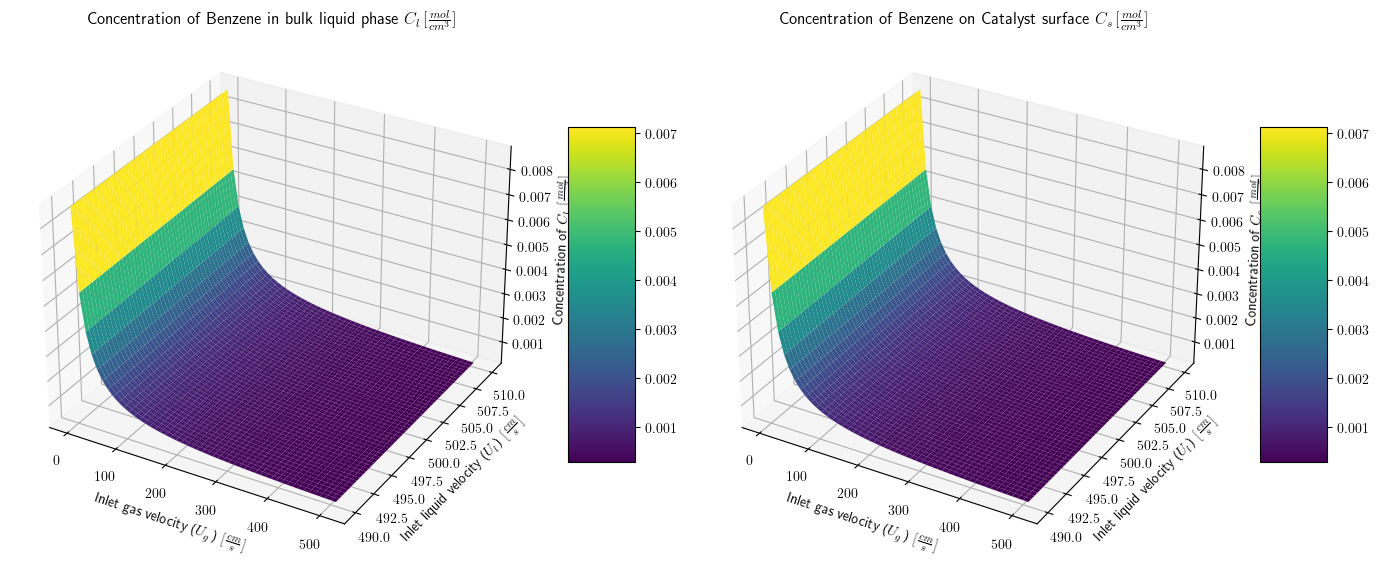

In [ ]:
# Plotting setup
fig = plt.figure(figsize=(14, 7))

# Plot for Concentration of Benzene in liquid bulk phase
ax1 = fig.add_subplot(121, projection='3d')

surf1 = ax1.plot_surface(Ug_grid, Ul_grid, Cl_grid, cmap='viridis', edgecolor='none')

# ax1.set_xlabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
ax1.set_xlabel(r'Inlet gas velocity ($U_g$) $[\frac{cm}{s}]$')
# ax1.set_xlabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')

# ax1.set_ylabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')
ax1.set_ylabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
# ax1.set_ylabel(r'Particle Diameter ($d_{p}$) [cm]')


ax1.set_zlabel(r'Concentration of $C_l$ $[\frac{mol}{cm^3}]$')

ax1.set_title(r'Concentration of Benzene in bulk liquid phase $C_l \, [\frac{mol}{cm^3}]$')

fig.colorbar(surf1, shrink=0.5, aspect=5, ax=ax1)

# Plot for Concentration of Benzene on the catalyst surface
ax2 = fig.add_subplot(122, projection='3d')

surf2 = ax2.plot_surface(Ug_grid, Ul_grid, Cs_grid, cmap='viridis', edgecolor='none')

# ax2.set_xlabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
ax2.set_xlabel(r'Inlet gas velocity ($U_g$) $[\frac{cm}{s}]$')
# ax2.set_xlabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')

# ax2.set_ylabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')
ax2.set_ylabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
# ax2.set_ylabel(r'Particle Diameter ($d_{p}$) [cm]')

ax2.set_zlabel(r'Concentration of $C_s$ $[\frac{mol}{cm^3}]$')

ax2.set_title(r'Concentration of Benzene on Catalyst surface $C_s \, [\frac{mol}{cm^3}]$')

fig.colorbar(surf2, shrink=0.5, aspect=5, ax=ax2)

plt.tight_layout()

plt.savefig("./graphs/Ug_Ul_fluidization.png")

plt.show()

## We want to know the conversion X profile of Benzene especially $C_l \simeq C_s$

$$
X_{Bz} = \dfrac{C_{Bz, 0} - C_{Bz}}{C_{Bz, 0}}
$$

In [ ]:
def calculate_X(CT, C0):
    """
    CT is the concentration of Benzene after start up
    C0 is the initial concentration of Benzene as inlet
    """
    numer = C0 - CT
    denom = C0
    
    return numer / denom

In [27]:
Xl_grid = np.zeros_like(Ul_grid)
Xs_grid = np.zeros_like(Ul_grid)

for i in range(len(Ug_values)):
    for j in range(len(Ul_values)):
        Cs_grid[i, j], _, Cl_grid[i, j] = compute_concentrations(T, xi, dp, 
                                                                 Cg0, Cl0, Ul_grid[i,j], 
                                                                 Ug_grid[i,j], He)
        Xl_grid[i,j], Xs_grid[i,j] = calculate_X(Cl_grid[i,j], Cl0), calculate_X(Cs_grid[i,j], Cl0)

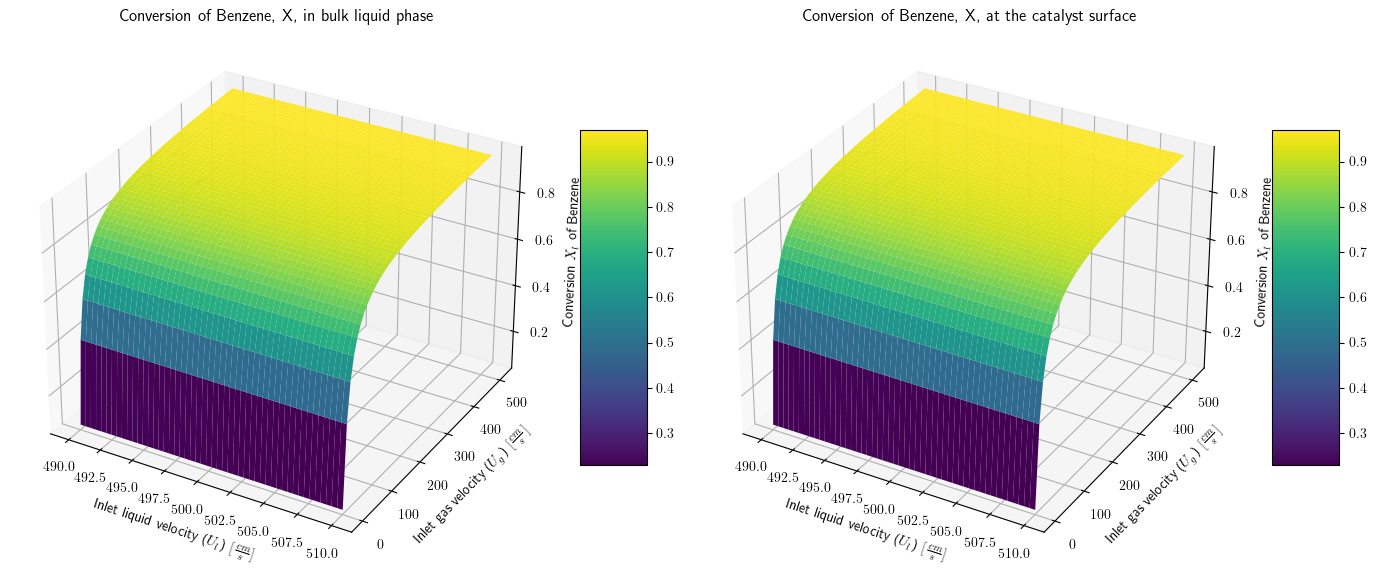

In [ ]:
fig = plt.figure(figsize=(14, 7))


ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(Ul_grid, Ug_grid, Xl_grid, cmap='viridis', edgecolor='none')


ax1.set_xlabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
# ax1.set_xlabel(r'Inlet gas velocity ($U_g$) $[\frac{cm}{s}]$')
# ax1.set_xlabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')

# ax1.set_ylabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')
# ax1.set_ylabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
ax1.set_ylabel(r'Inlet gas velocity ($U_g$) $[\frac{cm}{s}]$')
# ax1.set_ylabel(r'Particle Diameter ($d_{p}$) [cm]')

ax1.set_zlabel(r'Conversion $X_l$ of Benzene')

ax1.set_title(r'Conversion of Benzene, X, in bulk liquid phase')

fig.colorbar(surf1, shrink=0.5, aspect=5, ax=ax1)

# Plot for Concentration of Benzene on the catalyst surface
ax2 = fig.add_subplot(122, projection='3d')

surf2 = ax2.plot_surface(Ul_grid, Ug_grid, Xs_grid, cmap='viridis', edgecolor='none')

ax2.set_xlabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
# ax2.set_xlabel(r'Inlet gas velocity ($U_g$) $[\frac{cm}{s}]$')
# ax2.set_xlabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')

# ax2.set_ylabel(r'Dimensionless Reactor Length ($\xi = \frac{z}{H}$)')
# ax2.set_ylabel(r'Inlet liquid velocity ($U_l$) $[\frac{cm}{s}]$')
ax2.set_ylabel(r'Inlet gas velocity ($U_g$) $[\frac{cm}{s}]$')
# ax2.set_ylabel(r'Particle Diameter ($d_{p}$) [cm]')

ax2.set_zlabel(r'Conversion $X_l$ of Benzene')

ax2.set_title(r'Conversion of Benzene, X, at the catalyst surface')

fig.colorbar(surf2, shrink=0.5, aspect=5, ax=ax2)

plt.tight_layout()

plt.savefig("./graphs/Ug_Ul_conversion_fluidization.png")

plt.show()

### Since we know that the concenration, $C_l$ and $C_s$ do not vary along the reactor axis, thus the conversion at a fixed operating gas/liquidi velocity would be fixed. 

### If $U_l = 5 [m/s]$ and $U_g = 3 [m/s]$, then the conversion gradient $X$ is fixed at around 0.65 along the reactor.

## We now want to know the pressure profile of the fluidized bed reactor

From [5][6], we know that at steady-state the pressure drop is as follows:

$$
\dfrac{d P}{dz} = \left(\varepsilon_s \rho_s + \varepsilon_l \rho_l + \varepsilon_g \rho_g \right) \, g
$$

In [29]:
def calculate_dPdz(eps_l, eps_g, eps_s, rho_l=730, rho_g=2.9, rho_s=1.72e5, g=9.8):
    """Presssure gradient"""
    
    return g * (eps_l * rho_l + eps_g * rho_g + eps_s * rho_s)

## We now want to know the mass of solids needed in the bed

$$
M_p = \dfrac{\pi \cdot \varepsilon_s \cdot D_c^2 [m^2] \cdot H [m] \cdot \rho_p [\frac{kg}{m^3}]}{4}
$$

where 

$D_c = 3 [m]$ is the diameter of the columm 

$H = 3 [m]$ is the height of the column

$\rho_p = 1.72 \times 10^5 [\frac{kg}{m^3}]$ is the catalyst densiity

In [30]:
def calculate_Mp(eps_s, D_c=3, H=3, rho_p=1.72e5):
    
    numer = math.pi * eps_s * D_c**2 * H * rho_p
    
    return numer / 4

## Recall our other parameters

$d_p = 3.5 \times 10^{-3} \, [m]$

Catalyst density: $\rho_s = \rho_{AVE} = 1.72 \times 10^5 \, [\frac{kg}{m^3}]$

Liquid viscosity (obtained from Aspen simulation): $\mu = 1.7 \times 10^{-4} \, [Pa \cdot s] $ = $[\frac{kg}{m \cdot s}]$

Liquid density (obtained from Aspen simulation, same as above calculation): $\rho_{fluid} = 730 \, [\frac{kg}{m^3}]$

In [31]:
def calculate_holdups(U_g, U_l, d_p=3.5e-3, D_c=3, rho_p=1.72e5, rho_l=730, mu_l=1.7e-4):
    """
    Calculate gas, solids, and liquid holdups ensuring they sum to 1. (Begovich and Watson, 1978) [4]
    
    Parameters:
    - U_g: Gas velocity
    - U_l: Liquid velocity
    - d_p: Particle diameter
    - D_c: Column diameter
    - rho_p: Particle density
    - rho_l: Liquid density
    - mu_l: Liquid viscosity

    Returns:
    A tuple of (eps_g, eps_s, eps_l) representing gas, solids, and liquid holdups.
    """
    
    # Handle zero velocities upfront
    if U_g == 0:
        return (1.0, 0.0, 0.0)
    if U_l == 0:
        return (0.0, 0.0, 1.0)

    # Calculate holdups
    eps_g = max(0.048 * U_g**0.72 * d_p**0.168 * D_c**-0.125, 0.001)
    term1 = 0.371 * U_l**0.271 * U_g**0.041 * (rho_p - rho_l)**-0.316 * d_p**-0.268 * mu_l**0.055 * D_c**-0.033
    eps_s = max(1 - term1, 0.001)
    eps_l = max(1 - eps_g - eps_s, 0.001)

    # Adjust if the sum of eps_g, eps_s, and eps_l is not 1
    if eps_l < 0:
        excess = abs(eps_l)
        total = eps_g + eps_s
        eps_g, eps_s = eps_g - (eps_g / total) * excess, eps_s - (eps_s / total) * excess
        eps_l = 0.001

    return eps_g, eps_s, eps_l



In [32]:
# Ranges of inlet gas velocity U_g values 
Ug_values = np.linspace(1, 5.1, 50) # [m / s]

# Range of inlet liquid velocity U_l values 
Ul_values = np.linspace(4.9, 5.1, 50) # [m / s]


Ul_grid, Ug_grid = np.meshgrid(Ul_values, Ug_values)

# Initialize arrays for Cl and Cs values
eps_g_grid = np.zeros_like(Ul_grid)
eps_s_grid = np.zeros_like(Ul_grid)
eps_l_grid = np.zeros_like(Ul_grid)
bed_mass_grid = np.zeros_like(Ul_grid)
dPdz_grid = np.zeros_like(Ul_grid)


# Loop over each point in the grid to calculate holdups
for i in range(len(Ug_values)):
    for j in range(len(Ul_values)):
        eps_g_grid[i,j], eps_s_grid[i,j], eps_l_grid[i,j] = calculate_holdups(Ug_grid[i, j], Ul_grid[i, j])
        bed_mass_grid[i,j] = calculate_Mp(eps_s_grid[i,j])
        dPdz_grid[i,j] = calculate_dPdz(eps_l_grid[i,j], eps_g_grid[i,j], eps_s_grid[i,j])
        


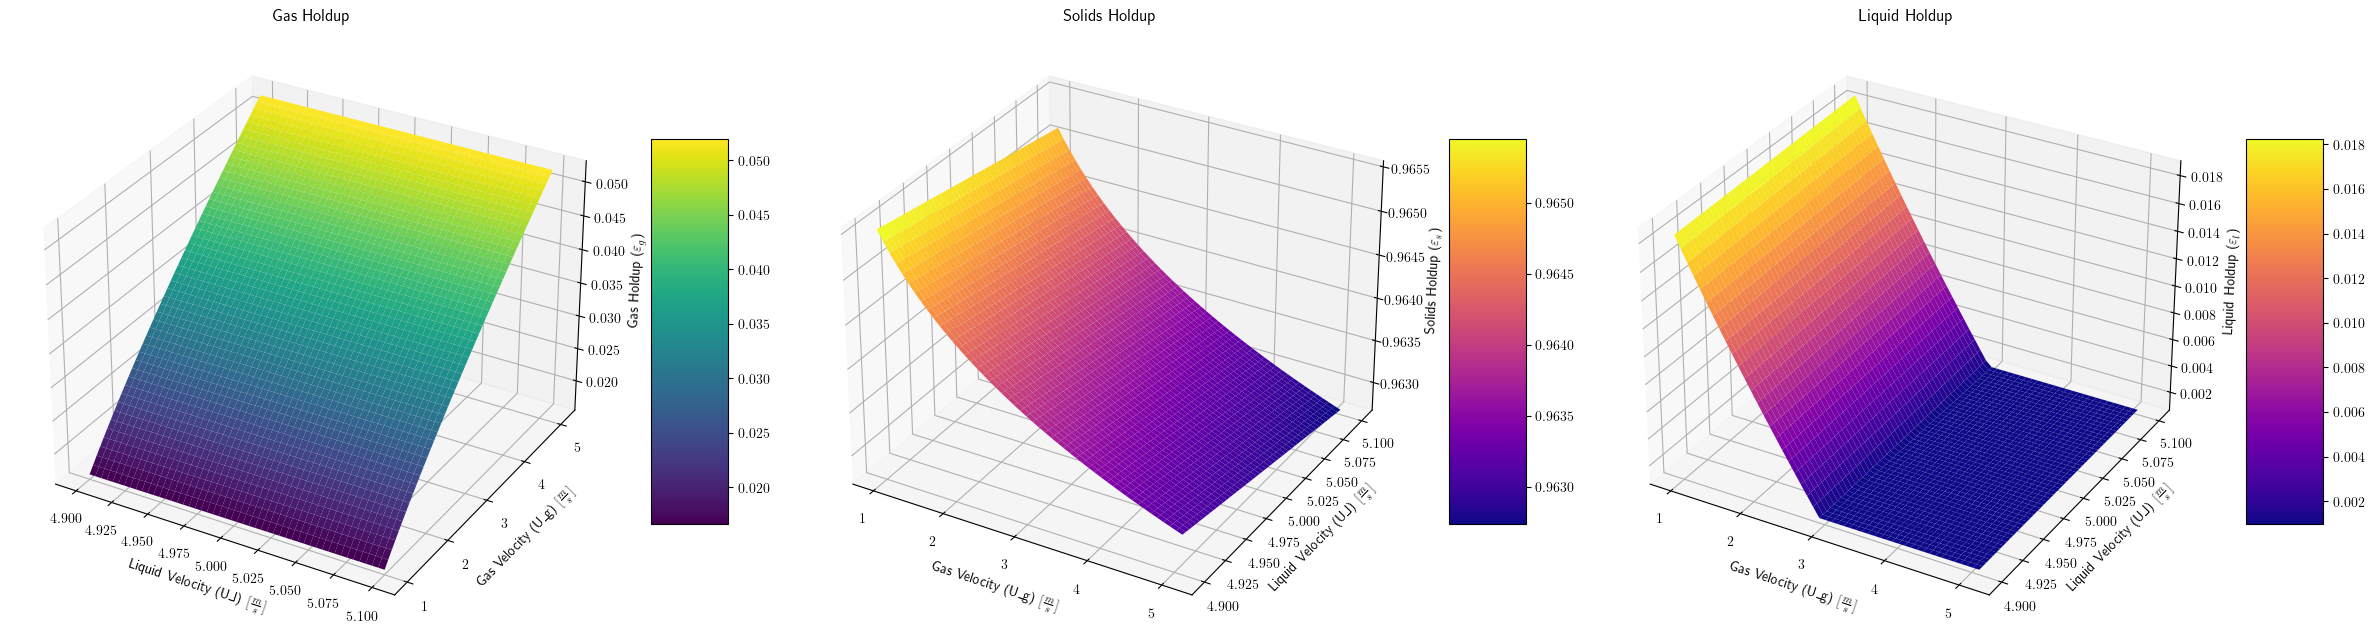

In [ ]:
# Plotting
fig = plt.figure(figsize=(24, 8))

# Gas holdups
ax1 = fig.add_subplot(131, projection='3d')

surf1 = ax1.plot_surface(Ul_grid, Ug_grid, eps_g_grid, cmap='viridis', edgecolor='none')

ax1.set_title('Gas Holdup')

ax1.set_xlabel(r'Liquid Velocity (U_l) $[\frac{m}{s}]$')
ax1.set_ylabel(r'Gas Velocity (U_g) $[\frac{m}{s}]$')
ax1.set_zlabel(r'Gas Holdup ($\varepsilon_g$)')

# Solid holdups
ax2 = fig.add_subplot(132, projection='3d')

surf2 = ax2.plot_surface(Ug_grid, Ul_grid, eps_s_grid, cmap='plasma', edgecolor='none')

ax2.set_title('Solids Holdup')

ax2.set_ylabel(r'Liquid Velocity (U_l) $[\frac{m}{s}]$')
ax2.set_xlabel(r'Gas Velocity (U_g) $[\frac{m}{s}]$')
ax2.set_zlabel(r'Solids Holdup ($\varepsilon_s$)')


# Liquid holdups
ax3 = fig.add_subplot(133, projection='3d')

surf3 = ax3.plot_surface(Ug_grid, Ul_grid, eps_l_grid, cmap='plasma', edgecolor='none')

ax3.set_title('Liquid Holdup')

ax3.set_xlabel(r'Gas Velocity (U_g) $[\frac{m}{s}]$')
ax3.set_ylabel(r'Liquid Velocity (U_l) $[\frac{m}{s}]$')
ax3.set_zlabel(r'Liquid Holdup ($\varepsilon_l$)')



# Add color bars for both plots to indicate the scale of holdups
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()

plt.savefig("./graphs/Ug_Ul_phase_holdups.png")

plt.show()

## Determining the total mass of solids in the fluidized bed

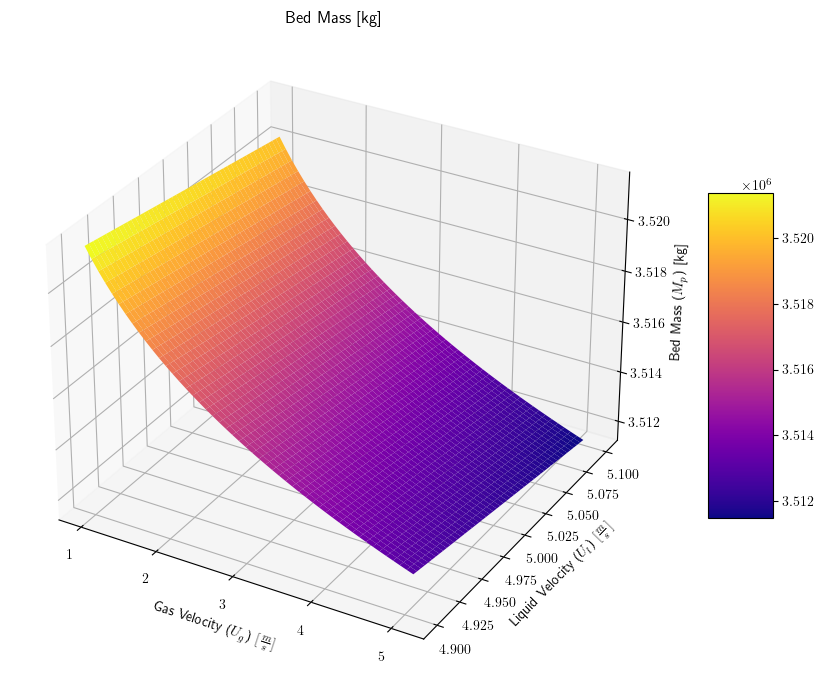

In [ ]:
# Plotting
fig = plt.figure(figsize=(10, 7))  # Adjusted figure size for better visibility
ax = fig.add_subplot(111, projection='3d')

# Plotting the gas holdup as an example
surf = ax.plot_surface(Ug_grid, Ul_grid, bed_mass_grid, cmap='plasma', edgecolor='none')

ax.set_title('Bed Mass [kg]')

ax.set_ylabel(r'Liquid Velocity ($U_l$) $[\frac{m}{s}]$')
ax.set_xlabel(r'Gas Velocity ($U_g$) $[\frac{m}{s}]$')


ax.set_zlabel(r'Bed Mass ($M_p$) [kg]')

fig.colorbar(surf, shrink=0.5, aspect=5)  # Adjust colorbar size if needed

plt.tight_layout()

plt.savefig("./graphs/Bed_mass.png")
plt.show()


## The bed has around $3.56 \times 10^6 [kg]$ of bulk catalyst particles (3924 ton) !!!

## We need to reduce the column diameter and bed height to reduce the amount of catalyst needed per fluidized bed reactor (to the order of magnitude to 1 ~ 10 tons)


## Since the reactor contents are well-mixed, and from [7] we know that the effect of column geometry has negligible impact on the gas holdup as the column diameter, $D_c > 0.15 [m]$ and $H_T > 3 [m]$

where $H_T$ is the height of the entire column, such that we will limit the bed height, $H$, to be lower than 1.5[m] and the column diameter to be within ranges of 0.15 and 0.2 [m] after performing a manual sensitivity analysis 

As shown in the following figure, the bed height would be covering the fluidized-bed section, while $H_T - H$ will cover the gas-liquid disengagement section, transition section and gas-liquid distributor section. 

Thus, since we know that the gas-liquid disengagement section to have a height of 2 [m] and the transition section to have a height of 0.5 [m] to avoid pneumatic conveying as the minimum fluidization velocity of the liquid is very close to the particle terminal velocity as evaluated. 


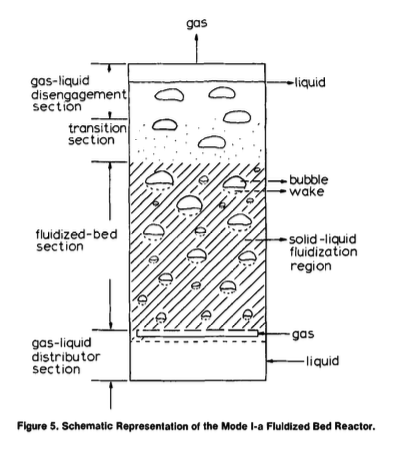

In [38]:
from IPython.display import Image
Image(filename='./Figures/Schematic_fluidized_bed.png', width=600, height=300)  # From Muroyama [8]

### We have manually perform a sensitivity analysis to iterate the values of the column diamter and column height and we get the following:

Inner column diameter, $D_c = 0.2 [m]$

Bed height, $H = 1.1 [m]$

In [39]:
# Loop over each point in the grid to calculate holdups
for i in range(len(Ug_values)):
    for j in range(len(Ul_values)):
        eps_g_grid[i,j], eps_s_grid[i,j], eps_l_grid[i,j] = calculate_holdups(Ug_grid[i, j], Ul_grid[i, j], 3.5e-3, 0.2)
        bed_mass_grid[i,j] = calculate_Mp(eps_s_grid[i,j], 0.2, 1.1)

        


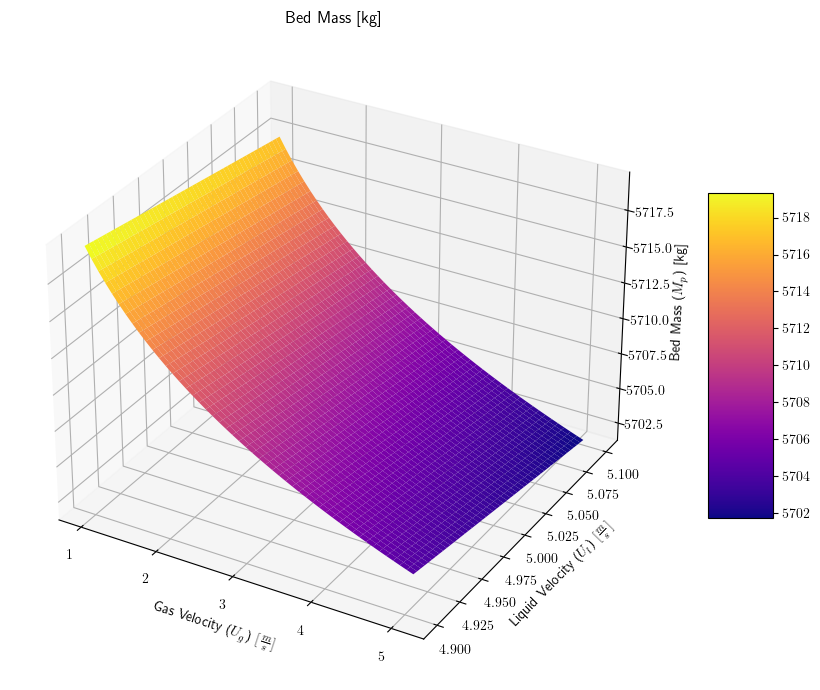

In [41]:
# Plotting
fig = plt.figure(figsize=(10, 7))  # Adjusted figure size for better visibility
ax = fig.add_subplot(111, projection='3d')

# Plotting the gas holdup as an example
surf = ax.plot_surface(Ug_grid, Ul_grid, bed_mass_grid, cmap='plasma', edgecolor='none')

ax.set_title('Bed Mass [kg]')

ax.set_ylabel(r'Liquid Velocity ($U_l$) $[\frac{m}{s}]$')
ax.set_xlabel(r'Gas Velocity ($U_g$) $[\frac{m}{s}]$')


ax.set_zlabel(r'Bed Mass ($M_p$) [kg]')

fig.colorbar(surf, shrink=0.5, aspect=5)  # Adjust colorbar size if needed

plt.tight_layout()

plt.savefig("./graphs/Bed_mass_updated.png")
plt.show()

## Thus we can see that now the weight of the bed is around 5790 [kg] = 6.4 [tons]

## In particular, we have used $D_c = 0.2 [m]$ in "Hydrodynamics part 1c" where we see that at the operating range of velocities, $U_g = 3 \, [\frac{m}{s}], U_l = 4.96 \, [\frac{m}{s}]$. 


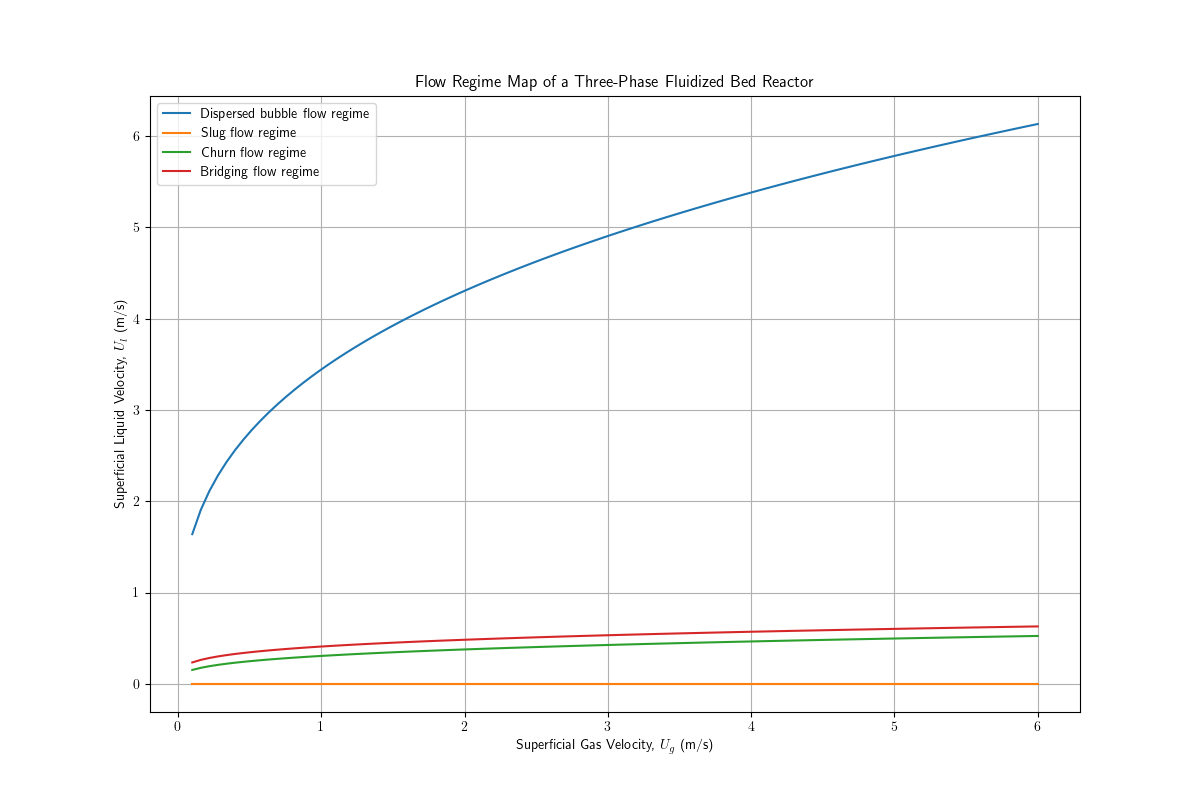

In [42]:
from IPython.display import Image
Image(filename='./graphs/Flow_Regime_Map.png', width=1500, height=1000)  

## It is in the dispersed bubble flow regime 

This verifies our assumption [7] as in high pressure, bubble coalesence is suppressed and enhances the rate of bubble breakup governed by internal circulation [9] rather than Rayleigh-Taylor instability. 

This results in smaller maximum bubble size due to high gas inertia and low gas-liquid surface tension, thus enhancing gas-liquid mass transfer effects (Hydrogen readily absorbed into the liquid then diffusing onto the catalyst surface). 

In the batch case, the initial stages of the reaction (aka partial hydrogenation of Benzene to produce Cyclohexene) is identified to be limited mainly from the hydrogen mass transfer effects [10]. 

Thus, by operating in the dispersed bubble flow regime which has promotes excellent gas-liquid mass transfer, the rate of surface reaction and the rate of mass transfer would be faster than the rate of solids mixing while maintaining a high selectivity of Cyclohexene as identified in the batch case the residence time for optimal reaction to produce Cyclohexene is less than 15 minutes [11]. 

In particular, the dispersed bubble flow is characterised by [12] as homogeneous flow. 

Thus, We can now assume a uniform pressure drop gradient along the reactor.

## Pressure profile in the fluidized bed


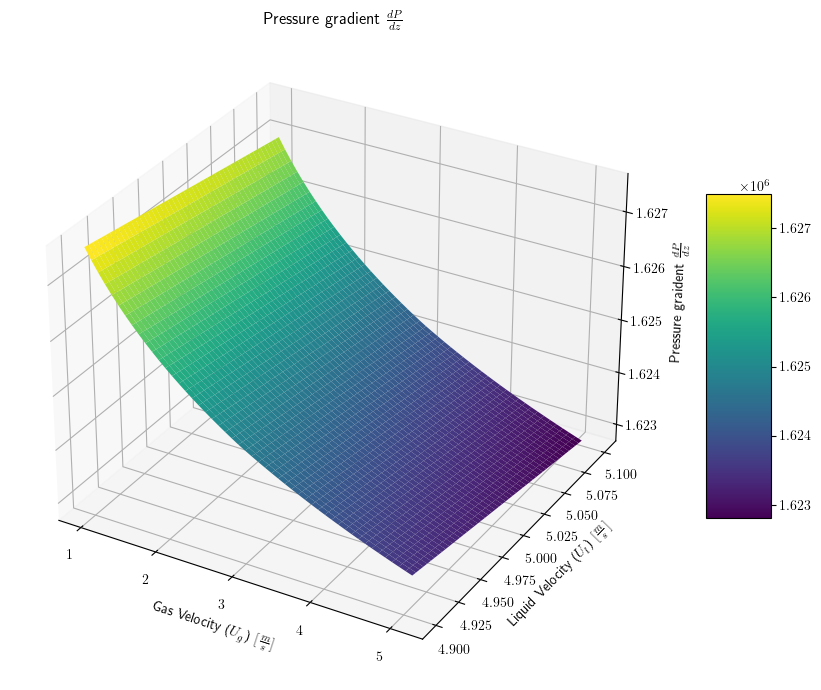

In [44]:
# Plotting
fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

# Plotting the gas holdup as an example
surf = ax.plot_surface(Ug_grid, Ul_grid, dPdz_grid, cmap='viridis', edgecolor='none')

ax.set_title(r'Pressure gradient $\frac{d P}{dz}$ ')
ax.set_ylabel(r'Liquid Velocity ($U_l$) $[\frac{m}{s}]$')
ax.set_xlabel(r'Gas Velocity ($U_g$) $[\frac{m}{s}]$')


ax.set_zlabel(r'Pressure graident $\frac{d P}{dz}$ ')

fig.colorbar(surf, shrink=0.5, aspect=5)  

plt.tight_layout()

plt.savefig("./graphs/Pressure_gradient.png")
plt.show()

We can see that at $U_l = 5 [\frac{m}{s}], U_g = 3 [\frac{m}{s}]$

$\dfrac{dP}{dz} \simeq 1.625 \times 10^6 \, \left[\dfrac{Pa}{m}\right] = 1.625 \, [\dfrac{M \, Pa}{m}]$

The pressure gradient is quite high and since the bed height is 1.1 [m]. 

Thus the overall pressure drop over the fluidized bed region (excluding plenum / distributor) is:

$$
\Delta P = 1.625 \, [\dfrac{M \, Pa}{m}] \cdot 1.1 [m] = 1.7875 [M \, Pa] \simeq 1.8 [M \, Pa]
$$


## We now want to estimate the expanded bed height 

Kelkar and Ng gives a relationship of expanded bed height versus static bed height [13]


$$
H_{exp} = \dfrac{H_{mf} \varepsilon_{s, mf}}{\varepsilon_s}
$$

where 

$H_{exp}$ is the expanded bed height [m]

$H_{mf}$ is the static bed height [m] (equal to the bed height at minimum fluidization)

$\varepsilon_{s, mf}$ is the solid holdup at minimum fluidization

$\varepsilon_s$ is the solid up in fixed bed conditions

## We know that the bed voidage at fixed bed conditions, $\varepsilon_s = 0.35$ as the sphericity, $\phi_s = 1$ [14]

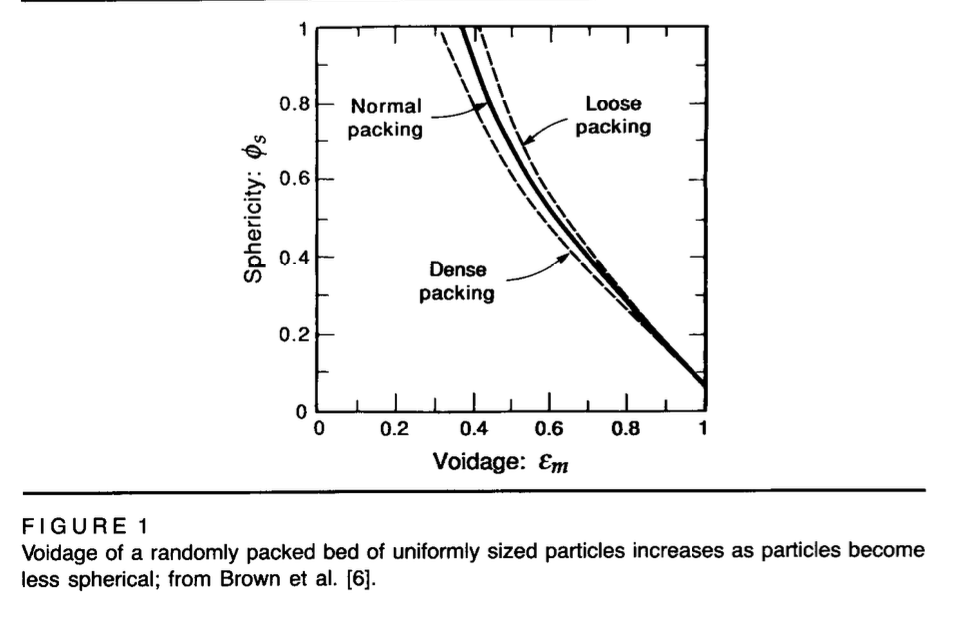

In [45]:
from IPython.display import Image
Image(filename='./Figures/Bed_voidage_fixed_kunii_brown.png', width=600, height=300)  # From [14]

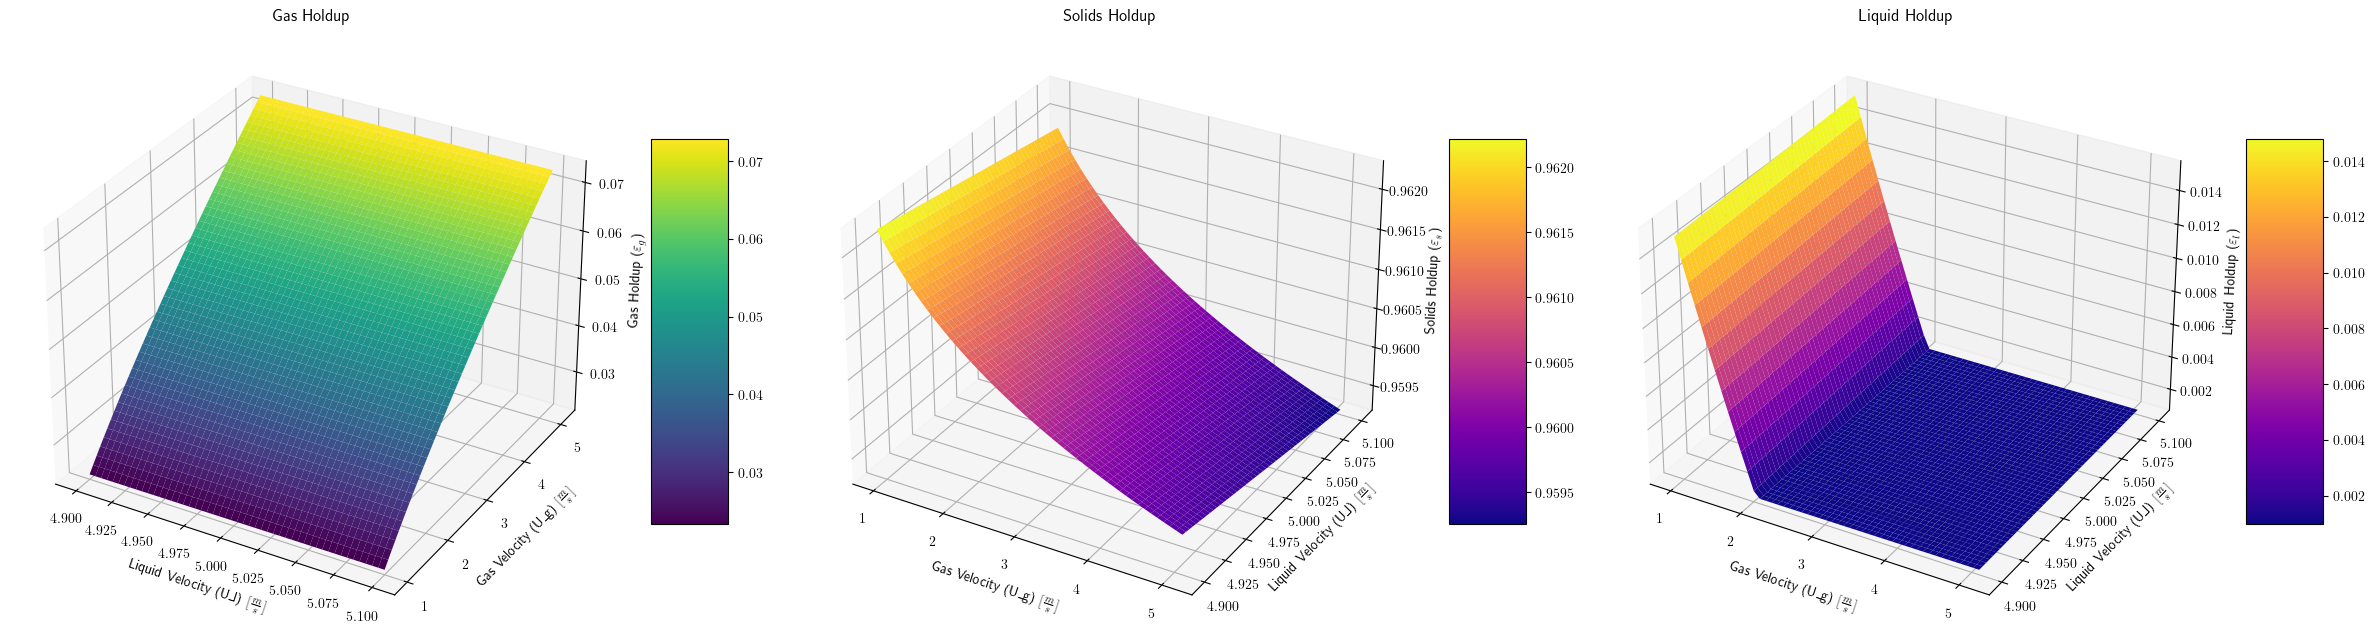

In [47]:
# Plotting
fig = plt.figure(figsize=(24, 8))

# Gas holdups
ax1 = fig.add_subplot(131, projection='3d')

surf1 = ax1.plot_surface(Ul_grid, Ug_grid, eps_g_grid, cmap='viridis', edgecolor='none')

ax1.set_title('Gas Holdup')

ax1.set_xlabel(r'Liquid Velocity (U_l) $[\frac{m}{s}]$')
ax1.set_ylabel(r'Gas Velocity (U_g) $[\frac{m}{s}]$')
ax1.set_zlabel(r'Gas Holdup ($\varepsilon_g$)')

# Solid holdups
ax2 = fig.add_subplot(132, projection='3d')

surf2 = ax2.plot_surface(Ug_grid, Ul_grid, eps_s_grid, cmap='plasma', edgecolor='none')

ax2.set_title('Solids Holdup')

ax2.set_ylabel(r'Liquid Velocity (U_l) $[\frac{m}{s}]$')
ax2.set_xlabel(r'Gas Velocity (U_g) $[\frac{m}{s}]$')
ax2.set_zlabel(r'Solids Holdup ($\varepsilon_s$)')


# Liquid holdups
ax3 = fig.add_subplot(133, projection='3d')

surf3 = ax3.plot_surface(Ug_grid, Ul_grid, eps_l_grid, cmap='plasma', edgecolor='none')

ax3.set_title('Liquid Holdup')

ax3.set_xlabel(r'Gas Velocity (U_g) $[\frac{m}{s}]$')
ax3.set_ylabel(r'Liquid Velocity (U_l) $[\frac{m}{s}]$')
ax3.set_zlabel(r'Liquid Holdup ($\varepsilon_l$)')



# Add color bars for both plots to indicate the scale of holdups
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

plt.tight_layout()

plt.savefig("./graphs/Ug_Ul_phase_holdups_verified.png")

plt.show()

## We can see that the solid holdup (fluidized) $\varepsilon_{mf}$ when $U_l \simeq 5 \left[\frac{m}{s}\right], U_g \simeq 3 \left[\frac{m}{s}\right]$ is about 0.960. 

Thus, we have


$$
H_{exp} = \dfrac{H_{mf} \, \varepsilon_{s, mf}}{\varepsilon_s} = \dfrac{1.1 [m] \, 0.960}{0.35} \simeq 3 [m]
$$

Thus the expanded bed height at fluidization conditions (operating conditions) is at 3 [m]

## We now want to determine the total height of the column (the height needed to avoid particle entrainment, aka height of the freeboard region or transport disengagement height)


We will assume that the height of the freeboard region to be 2 [m] which would be sufficient provided that it is not a spouted bed and provided the liquid / gas velocities are well controlled. 

We will leave the calculation of the actual height of the freeboard region to future work but one can calculate it based on the generalised wake model. 

Height of the freeboard region $H_m$ can be represented in terms of wake formation and shedding, provided by Miyahara [15]:

$$
H_m = \dfrac{U_b \, N_m}{f_c}
$$

where 

$U_b$ is the Bubble rise velocity [m/s]

$f_c$ is the frequency of vortex shedding

$N_m$ is the shedding cycles before the release of all particles from the wake






# References

[1]: F. S. Mjalli and A. Al-Mfargi, “Artificial Neural Approach for Modeling the Heat and Mass Transfer Characteristics in Three-Phase Fluidized Beds,” Industrial & Engineering Chemistry Research, vol. 47, no. 13, pp. 4542–4552, May 2008, doi: https://doi.org/10.1021/ie0715714.

[2]: Sang Done Kim and C. H. Kim, “Axial dispersion characteristics of three phase fluidized beds.,” vol. 16, no. 3, pp. 172–178, Jan. 1983, doi: https://doi.org/10.1252/jcej.16.172.

[3]: D. C. Arters and L.-S. Fan, “Solid-liquid mass transfer in a gas-liquid-solid fluidized bed11This paper was presented at the 1984 Annual Meeting of the American Institute of Chemical Engineers, 25-30 November.,” Chemical Engineering Science, vol. 41, no. 1, pp. 107–115, 1986, doi: https://doi.org/10.1016/0009-2509(86)85203-4.

[4]: J. M. Begovich and J. S. Watson, “Hydrodynamic characteristics of three-phase fluidized beds,” www.osti.gov, Jan. 01, 1978. https://www.osti.gov/biblio/7208327 (accessed Feb. 17, 2024).

[5]: K. D. Wisecarver and L.-S. Fan, “Optimum particle size in a gas-liquid-solid fluidized bed catalytic reactor,” Chemical Engineering Science, vol. 43, no. 10, pp. 2741–2750, 1988, doi: https://doi.org/10.1016/0009-2509(88)80017-4.

[6]: “Optimum Particle Size in Catalytic Reactors — An Example of Reactor Analyses for Modes E-I-a-1, E-I-a-2 and T-I-a-2 (Figure 1.3),” Elsevier eBooks, pp. 735–752, Jan. 1989, doi: https://doi.org/10.1016/b978-0-409-95179-0.50018-0.

[7]: W.-C. Yang, “Handbook of fluidization and fluid-particle systems,” China Particuology, vol. 1, no. 3, p. 137, Jul. 2003, doi: https://doi.org/10.1016/s1672-2515(07)60126-2.

[8]: K. Muroyama and L.-S. Fan, “Fundamentals of gas-liquid-solid fluidization,” AIChE Journal, vol. 31, no. 1, pp. 1–34, Jan. 1985, doi: https://doi.org/10.1002/aic.690310102.

[9]: X. Luo, D. J. Lee, R. Lau, G. Yang, and L.-S. Fan, “Maximum stable bubble size and gas holdup in high-pressure slurry bubble columns,” AIChE Journal, vol. 45, no. 4, pp. 665–680, Apr. 1999, doi: https://doi.org/10.1002/aic.690450402.

[10]: J. Struijk, M. d’Angremond, W. J. M. L. Regt, and J. J. F. Scholten, “Partial liquid phase hydrogenation of benzene to cyclohexene over ruthenium catalysts in the presence of an aqueous salt solution,” Applied Catalysis A: General, vol. 83, no. 2, pp. 263–295, Apr. 1992, doi: https://doi.org/10.1016/0926-860x(92)85039-e.

[11]: Y. Song, S. Zhi, G. Fan, L. Yang, and F. Li, “Regulating Surface‐Interface Structures of Zn‐Incorporated LiAl‐LDH Supported Ru Catalysts for Efficient Benzene Hydrogenation to Produce Cyclohexene,” Chemcatchem, vol. 14, no. 14, May 2022, doi: https://doi.org/10.1002/cctc.202200125.

[12]: J.-P. . Zhang, J. R. Grace, N. Epstein, and K. S. Lim, “Flow regime identification in gas-liquid flow and three-phase fluidized beds,” Chemical Engineering Science, vol. 52, no. 21–22, pp. 3979–3992, Nov. 1997, doi: https://doi.org/10.1016/s0009-2509(97)00241-8.

[13]: V. V. Kelkar and K. M. Ng, “Development of fluidized catalytic reactors: Screening and scale-up,” AIChE Journal, vol. 48, no. 7, pp. 1498–1518, Jul. 2002, doi: https://doi.org/10.1002/aic.690480714.

[14]: George Granger Brown, Unit Operations. 1950. In: D. Kunii and O. Levenspiel, “Fluidization and Mapping of Regimes,” Fluidization Engineering, pp. 61–94, 1991, doi: https://doi.org/10.1016/b978-0-08-050664-7.50009-3.

[15]: T. Miyahara, K. Tsuchiya, and L.-S. Fan, “Mechanism of particle entrainment in a gas-liquid-solid fluidized bed,” AIChE Journal, vol. 35, no. 7, pp. 1195–1198, Jul. 1989, doi: https://doi.org/10.1002/aic.690350715.
